# Classification of Thorax diseases using NIH-Chest-Xray Dataset(Subset)

In [2]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D

from keras.models import load_model

## Dataset:

In [3]:
print(os.listdir("./Datasets/"))

['images_subset', 'preprocessing.py', 'images', '.ipynb_checkpoints', 'labels', 'iris.csv', 'Data_Entry_2017.csv', 'train-subset.csv', 'BBox_List_2017.csv', 'test.csv', 'valid-subset.csv']


In [4]:
train_df = pd.read_csv('./Datasets/train-subset.csv')
dev_df = pd.read_csv('./Datasets/valid-subset.csv')
test_df = pd.read_csv('./Datasets/test.csv')

train_df.head(3)
print(f'Number of Training Samples : {train_df.shape[0]}')
print(f'Number of Dev Samples : {dev_df.shape[0]}')
print(f'Number of Test Samples : {test_df.shape[0]}')

train_df.head(3)

Number of Training Samples : 1000
Number of Dev Samples : 109
Number of Test Samples : 420


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0


## Parameters

In [5]:
IMG_SIZE = (256,256)
IMG_DIR = './Datasets/images_subset/'

labels_train = train_df.columns[2:-1]
labels_dev = dev_df.columns[2:-1]
labels_test = test_df.columns[2:-1]

print(labels_train)

Index(['Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
       'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'PatientId',
       'Pleural_Thickening', 'Pneumonia'],
      dtype='object')


## Check Data Leakage

Check the presence of same patient in test set which are also present in test, dev set. 

- Funciton @`./Utils/eval_utils/check_data_leakage()`

In [6]:
from Utils.eval_utils import check_data_leakage

leak_test_train = check_data_leakage(train_df, test_df, 'PatientId')
leak_dev_test = check_data_leakage(dev_df, test_df, 'PatientId')

print(f"Train-Test Overlap: {leak_test_train}")
print(f"Dev-Test Overlap: {leak_dev_test}")

Train-Test Overlap: False
Dev-Test Overlap: False


## Image Generator

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# Training Data Generator 
def get_train_generator(df, image_dir, x_col, y_cols
                        , shuffle=True, batch_size=8, seed=111, img_dim=(256,256)):
    
    print("getting train generator...")
    
    # Keras @ImageDataGenerator Class
    image_generator = ImageDataGenerator( samplewise_center=True,
                                        samplewise_std_normalization= True, 
                                        shear_range=0.1,
                                        zoom_range=0.15,
                                        rotation_range=5,
                                        width_shift_range=0.1,
                                        height_shift_range=0.05,
                                        horizontal_flip=True, 
                                        vertical_flip = False, 
                                        fill_mode = 'reflect' )
    
    # Keras @ImageDataGenerator(class).flow_form_dataframe(fn)
    generator = image_generator.flow_from_dataframe( dataframe=df,
                                                    directory=None,
                                                    x_col=x_col,
                                                    y_col=y_cols,
                                                    class_mode="raw",
                                                    batch_size=batch_size,
                                                    shuffle=shuffle,
                                                    seed=seed,
                                                    target_size=img_dim )
    
    return generator

In [14]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1,  img_dim=(256,256)):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size= img_dim )
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size= img_dim)

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size= img_dim )
    
    return valid_generator, test_generator

### Image Loader

In [15]:
IMAGE_DIR = "./Datasets/images_subset/"

train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels_train)

dev_generator, test_generator= get_test_and_dev_generator(dev_df, test_df, train_df, IMAGE_DIR, "Image", labels_dev)

getting train generator...
Found 0 validated image filenames.
getting train and dev generators...
Found 1000 validated image filenames.
Found 1 validated image filenames.
Found 420 validated image filenames.


In [16]:
print(type(train_generator))

<class 'tensorflow.python.keras.preprocessing.image.DataFrameIterator'>


#### Normalized Training Image Sample

In [18]:
x, y = train_generator.next(0)
plt.imshow(x[0]);

TypeError: next() takes 1 positional argument but 2 were given

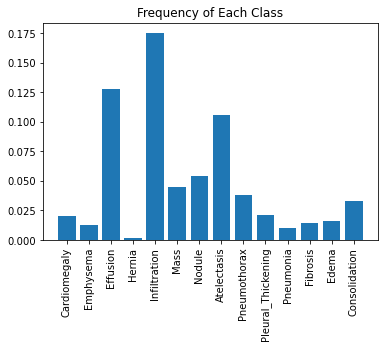

In [85]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [86]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

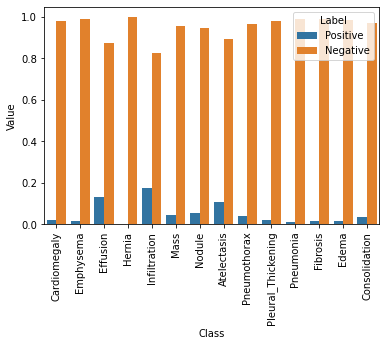

In [87]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [88]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

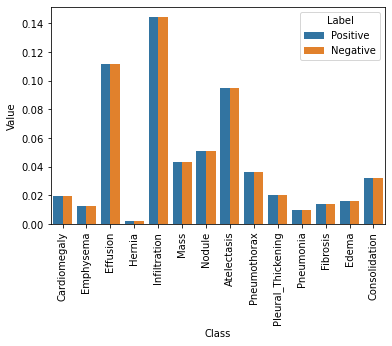

In [89]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [90]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                             + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon))) #complete this line
        return loss
    return weighted_loss

## Model
***

### Parameters

In [91]:
epochs = 5
batch_size = 32
image_shape = (128, 128, 3)
model_learn_rate = 0.001

In [94]:
# from keras.optimizers import Adam
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

from Model.Xnet import Xnet

model = Xnet(model2load='densenet121',
                    percent2retrain=0.2,
                    image_dimensions=(128,128,3),
                    n_classes=14).get_model()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
flatten_12 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               8389120   
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 14)                7182      
Total params: 15,433,806
Trainable params: 10,115,470
Non-trainable params: 5,318,336
_________________________________________________________________


In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [61]:
optimizer = Adam(lr=model_learn_rate,
                     beta_1=0.9,
                     beta_2=0.999,
                     epsilon=1e-08,
                     amsgrad=False)

model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights),metrics=['acc'])

with open("model_subset.json", "w") as json_model:
        json_model.write(model.to_json())

### Training Model

### Evaluation

***